https://archive.ics.uci.edu/ml/datasets/automobile

Пожалуйста, проанализируйте представленные данные (dataset.csv) и ответьте на несколько
вопросов:
1. Придумайте и опишите наибольшее число вариантов использования этих данных. Для
решения каких практических задач их можно применить?
2. Выберите одну из описанных вами задач и реализуйте ее решение на Python / R при
помощи оптимальной на ваш взгляд модели. Опишите, почему вы выбрали именно эту
модель.
3. Опишите ваш подход к предварительному анализу (в т.ч. визуализации) и обработке
данных, работе с признаками, кросс валидацией, настройкой модели и ее оценкой.
Объясните выбор того или иного решения и, по возможности, сравните с
альтернативами.
4. Опишите, как бы вы улучшили модель из пункта 2, если бы у вас было больше времени
и существенно больший датасет.


Варианты использования:
- по характеристикам автомобиля предсказывать: 
    расход топлива, цену, величину расходов на содержание, категорию риска страхования
- по габаритам определять примерный вес кузова, колесную базу
- по характеристикам мотора определять его примерную мощность

Попробуем построить модель для определения расхода топлива автомобиля.

In [85]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 500)

In [86]:
# сразу заменяем ? на nan
df = pd.read_csv('dataset.csv', na_values='?')

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized-losses    164 non-null float64
make                 205 non-null object
fuel-type            205 non-null object
aspiration           205 non-null object
num-of-doors         203 non-null object
body-style           205 non-null object
drive-wheels         205 non-null object
engine-location      205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-type          205 non-null object
num-of-cylinders     205 non-null object
engine-size          205 non-null int64
fuel-system          205 non-null object
bore                 201 non-null float64
stroke               201 non-null float64
compression-ratio    205 non-null float64
horsepower           203 non-

In [88]:
df['num-of-cylinders'].unique()

array(['four', 'six', 'five', 'three', 'twelve', 'two', 'eight'],
      dtype=object)

In [89]:
doors_map = {'four': 4, 'two': 2, np.nan: 4}
cylinder_map = {'four': 4, 'six': 6, 'five': 5, 'three': 3, 'twelve': 12, 'two': 2, 'eight': 8}
df['num-of-doors'] = df['num-of-doors'].map(doors_map) 
df['num-of-cylinders'] = df['num-of-cylinders'].map(cylinder_map)

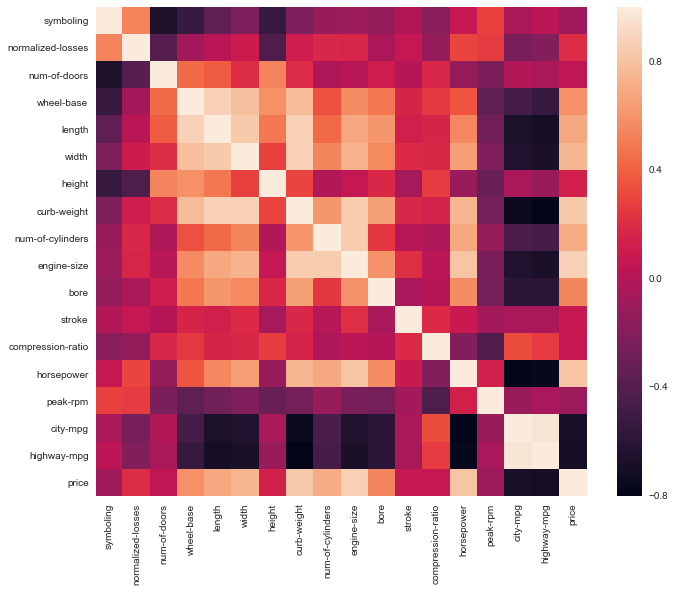

In [90]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(df.corr())
plt.show()

In [91]:
df[['city-mpg', 'highway-mpg']].describe()

,city-mpg,highway-mpg
count,205.000000,205.000000
mean,25.219512,30.751220
std,6.542142,6.886443
min,13.000000,16.000000
25%,19.000000,25.000000
50%,24.000000,30.000000
75%,30.000000,34.000000
max,49.000000,54.000000


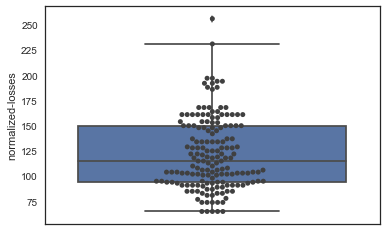

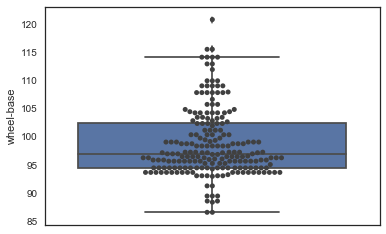

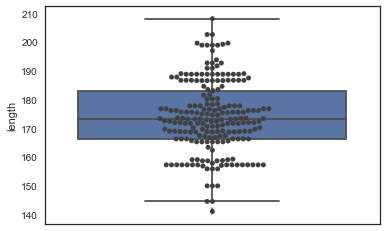

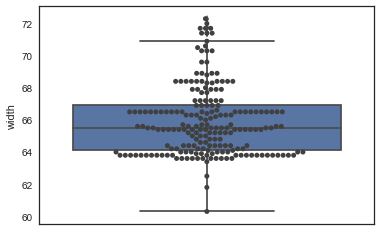

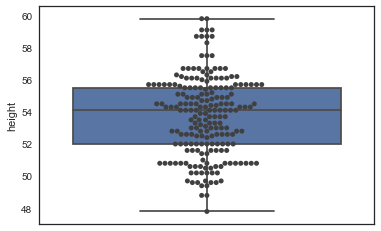

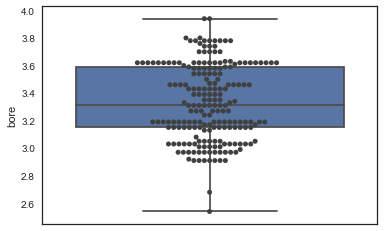

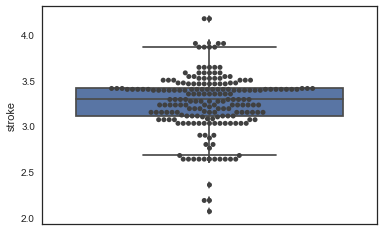

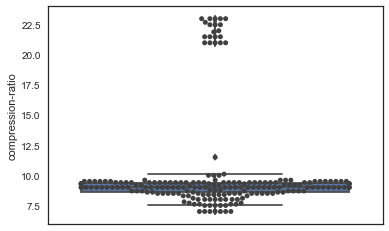

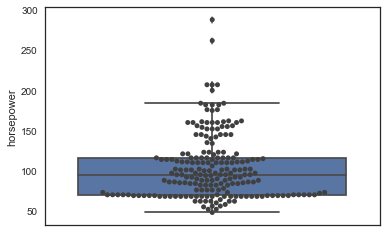

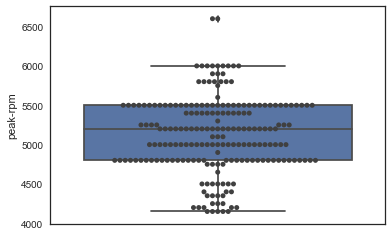

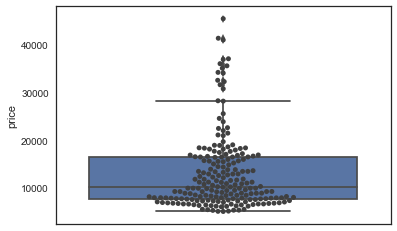

In [92]:
cols = list(df.columns[np.where(df.dtypes==np.float)])
for col in cols:
    sns.boxplot(y=col, data=df)
    sns.swarmplot(y=col, data=df, color="0.25")
    plt.show()

In [93]:
# проверим, что compression-ratio > 20 только у дизелей
df[df['compression-ratio'] > 20]['fuel-type'].unique()

array(['diesel'], dtype=object)

Поскольку в датасете достаточно много категориальных признаком, которые придется кодировать, то логично попробовать CatBoost,
главной фичей которого является работа с категориальными признаками. 
Просто скормим ему датасет и покажем, какие столбцы нужно закодировать. 

In [94]:
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import cross_val_score


In [95]:
X = df.drop(['city-mpg', 'highway-mpg'], axis=1)
y = df['city-mpg']

Т.к. данных не то чтоб прям совсем мало и у нас нет какой-либо временной зависимости,
то можно использовать кросс-валидацию на нескольких фолдах.

In [96]:
pool = Pool(X, y, cat_features=np.where(X.dtypes != np.float)[0])
params = {'iterations': 50, 'depth': 4, 'learning_rate': 0.2, 'loss_function':'RMSE', 'logging_level': 'Silent'}
scores = cv(pool, params, fold_count=3)
scores

,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,21.302544,0.818664,21.392534,0.178953
1,17.553063,0.757259,17.617514,0.176381
2,14.585728,0.625896,14.669901,0.113621
3,12.130014,0.616009,12.277074,0.045350
4,10.125088,0.466428,10.310528,0.055849
5,8.588699,0.494949,8.765872,0.038370
6,7.393812,0.475952,7.567735,0.064586
7,6.444803,0.485188,6.558486,0.069439
8,5.720178,0.442618,5.820743,0.152065
9,5.101738,0.405942,5.204326,0.094863


В целом неплохой результат, для того, чтоб прикинуть расход топлива вполне подойдет.
Отклонение в ошибке на фолдах не велико, вероятно, мы не переобучились.
Посмотрим, какие признаки модель считает наиболее важными.

In [97]:
params['calc_feature_importance'] = True
catReg = CatBoostRegressor(**params).fit(X, y, cat_features=np.where(X.dtypes != np.float)[0])
feature_importance = catReg.get_feature_importance(pool)

In [98]:
imp = {colname: feature_importance[i] for i, colname in enumerate(X.columns)}
for col in sorted(imp, key=imp.get, reverse=True):
    print(col, imp[col])

price 14.70884196789547
compression-ratio 13.983201297177628
body-style 11.99718122836885
engine-type 11.61011954238331
fuel-system 11.040935228445978
num-of-cylinders 7.542743869524987
horsepower 6.688773479325549
num-of-doors 5.738889409726659
peak-rpm 4.283556396503785
length 3.0192538962948765
symboling 2.3839541698774434
drive-wheels 1.5825164706335315
width 1.1203967911897745
make 1.0736011519665816
bore 1.0238544315868077
wheel-base 1.023545560218966
stroke 0.5834706741753676
aspiration 0.34342669824248906
normalized-losses 0.251737736461948
fuel-type 0.0
engine-location 0.0
height 0.0
curb-weight 0.0
engine-size 0.0


Попробуем еще простую линейную модель и сравним важность признаков.
Категориальные признаки попробуем закодировать готовым target encoding.

In [99]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
import category_encoders

In [100]:
df = df.fillna(df.mean())
enc = category_encoders.TargetEncoder()
df = df.rename(columns={"fuel-system": "fuel_system", "engine-type": "engine_type", "drive-wheels": "drive_wheels", "body-style": "body_style"})
X2 = df.drop(['city-mpg', 'highway-mpg'], axis=1)
y = df['city-mpg']

X_transformed = enc.fit_transform(X2, y)

In [101]:
lasso = Lasso(alpha=0.1)
scores = cross_val_score(lasso, X_transformed, y, cv=3, scoring='neg_mean_squared_error')
print(np.sqrt(np.absolute(scores)))

[3.73039982 2.38520959 3.16590792]


In [102]:
lasso.fit(X_transformed, y)
imp = {colname: lasso.coef_[i] for i, colname in enumerate(X_transformed.columns)}
for col in sorted(imp, key=imp.get, reverse=True):
    print(col, imp[col])

compression-ratio 0.48565253506277534
num-of-cylinders 0.34976130831484664
make 0.23024328667248417
fuel_system 0.14844887235886642
engine_type 0.12715449735483403
aspiration 0.08847274851266534
wheel-base 0.07159253275470176
engine-location 0.044593322084328535
height 0.04015094351282899
engine-size 0.025699841838987544
width 0.01876618348400167
drive_wheels 0.007342472005374213
normalized-losses 0.0012396500620117919
price 1.3180150120686457e-05
num-of-doors -0.0
bore -0.0
stroke -0.0
fuel-type -0.0
body_style 0.0
peak-rpm -0.0007522384374470786
curb-weight -0.00691577377664877
horsepower -0.03712176760213446
length -0.09900481428496982
symboling -0.25142809309940606


Обе модели выделили количество цилиндров и степень сжатия
catboost выглядит адекватнее по ошибке на cv и по важности признаков

Если бы времени и данных было больше я бы попробовал
- поубирать сомнительные признаки, которые не должны влиять на таргет
- заморочиться с чисткой, используя знания предметной области
- сравнить разные способы кодирования категориальных признаков, возможно линейная модель будет лучше работать с One Hot
- посмотреть, где и насколько ошибается модель, возможно попробовать другую метрику для ошибок
С rmse мы не даем модели сильно ошибаться на отдельных сэмплах
- выбрать параметры модели через GridSearch или RandomGridSearch, а не наугад
- xgboost (не с one hot)
- из интереса представить количество цилиндров не категориальным признаком :)